<a href="https://colab.research.google.com/github/levynlee/ESAA/blob/main/1111_%ED%95%84%EC%82%AC%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**4. 모델 세부 설정**

In [2]:
import tensorflow as tf

# 케라스의 내장 데이터셋에서 mnist 데이터셋 로드
mnist = tf.keras.datasets.mnist

# load_data()로 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 로드된 데이터셋 확인
print('train set: ', x_train.shape, y_train.shape)
print('test set: ', x_test.shape, y_test.shape)

# 데이터 정규화
x_train = x_train / x_train.max()  # max: 255
x_test = x_test / x_test.max()     # max: 255

train set:  (60000, 28, 28) (60000,)
test set:  (10000, 28, 28) (10000,)


###**4-1. 초기값 설정**

Desne 레이어는 기본 초기화 방법으로 Glorot Uniform 초기화 방법이 설정되어 있다.

In [3]:
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()['kernel_initializer']

{'module': 'keras.initializers',
 'class_name': 'GlorotUniform',
 'config': {'seed': None},
 'registered_name': None}

기본값으로 설정된 초기화 방법을 변경하려면 kernel_initializer 매개변수에 설정한다.

In [4]:
# 문자열 초기화
dense = tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')
print(dense.get_config()['kernel_initializer'])

# 클래스 인스턴스 초기화
he_normal = tf.keras.initializers.HeNormal()
dense = tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation='relu')
print(dense.get_config()['kernel_initializer'])

{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}
{'module': 'keras.initializers', 'class_name': 'HeNormal', 'config': {'seed': None}, 'registered_name': None}


케라스에서 지원하는 자주 사용되는 초기화 목록
- glorot_normal, glorot_uniform: 글로럿 초기화(Xavier 초기화)
- lecun_normal, lecun_uniform: Yann Lecun 초기화
- he_normal, he_uniform: He 초기화
- random_normal, random_uniform: 정규 분포, 연속균등 분포 초기화

###**4-2. 규제(Regulation)**

모델의 과대적합을 해소하기 위해 L1, L2 규제를 적용하기도 한다. 텐서플로 케라스 레이어는 기본값으로 규제를 적용하지 않는다. (kernel_regulation: None)

In [5]:
# 기본값
dense = tf.keras.layers.Dense(256, activation='relu')
dense.get_config()

{'name': 'dense_3',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'module': 'keras.initializers',
  'class_name': 'GlorotUniform',
  'config': {'seed': None},
  'registered_name': None},
 'bias_initializer': {'module': 'keras.initializers',
  'class_name': 'Zeros',
  'config': {},
  'registered_name': None},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [6]:
# L1 규제 적용
dense = tf.keras.layers.Dense(256, kernel_regularizer='l1', activation='relu')
print(dense.get_config()['kernel_regularizer'])

# 클래스 인스턴스 적용, alpha=0.1 변경
regularizer = tf.keras.regularizers.l1(l1=0)
dense = tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu')
print(dense.get_config()['kernel_regularizer'])

{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.009999999776482582}, 'registered_name': None}
{'module': 'keras.regularizers', 'class_name': 'L1', 'config': {'l1': 0.0}, 'registered_name': None}


###**4-3. 드롭아웃(Dropout)**

딥러닝 모델의 가장 큰 난제는 과대적합 문제이다. 딥러닝 모델의 층이 넓고 깊어질 때 모델은 훈련에 주어진 샘플에 과하게 적합하도록 학습하는 경향이 있다. 따라서 훈련할 때 만나지 못한 새로운 데이터에 대해서는 좋지 않은 예측력을 보일 때가 많다. 드롭아웃은 모델의 과대적합 문제를 해결하기 위해 제안된 아이디어이며, 실무적으로 상당히 좋은 효과를 보이는 것으로 알려져 있다.  

노드의 일부 신호를 임의로 삭제하게 되면, 모델이 쉽게 과대적합되는 것을 방지할 수 있다. 모델이 학습하는 가중치 파라미터의 개수가 현저하게 줄어들게 되기 때문이다.  

중요한 점은 모델이 훈련할 때는 드롭아웃이 적용되어 노드 중 일부만 훈련하게 되지만, 예측 시점에는 모든 노드들이 활용된다는 것이다.

In [7]:
# Dropout 25% 비율 적용 (25%의 노드가 삭제)
tf.keras.layers.Dropout(0.25)

<Dropout name=dropout, built=False>

###**4-4. 배치 정규화(Batch Normalization)**

배치 정규화는 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일을 정규화한다. 다음 층으로 데이터가 전달되기 전에 스케일을 조정하기 때문에 보다 안정적인 훈련이 가능하고 성능을 크게 향상시킬 수 있다.

In [9]:
# Model A: Dense + ReLU
model_a = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [10]:
# Model B: Dense + BatchNorm + ReLU
model_b = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(64),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(32),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # 배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])
model_b.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,034 (207.16 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

데이터의 개수가 적은 편인 mnist 손글씨 데이터셋에서는 큰 차이를 보이지 않을 수 있지만, 더 크고 복잡한 데이터셋에 대해서는 배치 정규화 유무가 모델 성능에 크게 영향을 미치는 경우도 있으므로 배치 정규화를 적극 적용해볼 필요가 있다.

###**4-5. 활성화(activation) 함수**

In [11]:
# LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

# LeakyReLU, alpha=0.2로 변경
tf.keras.layers.LeakyReLU(alpha=0.2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


<LeakyReLU name=leaky_re_lu_1, built=False>

In [13]:
# Model C: Dense + BatchNorm + LeakyReLU(0,2)
model_c = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(64),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha=0.2 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(32),
    # 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    # LeakyReLU, alpha=0.2 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(10, activation='softmax')
])

# 모델 요약
model_c.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,034 (207.16 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

생성한 3개 모델을 동일한 조건으로 10번의 epoch 동안 훈련한 후에 수렴 속도를 확인한다.

In [14]:
model_a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model A: Dense + ReLU
history_a = model_a.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=10)

# Model B: Dense + BatchNorm + ReLU
history_b = model_b.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=10)

# Model C: Dense + BatchNorm + LeakyReLU(0,2)
history_c = model_c.fit(x_train, y_train,
                        validation_data=(x_test, y_test),
                        epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8476 - loss: 0.5151 - val_accuracy: 0.9533 - val_loss: 0.1627
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9588 - loss: 0.1383 - val_accuracy: 0.9668 - val_loss: 0.1178
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9699 - loss: 0.0979 - val_accuracy: 0.9674 - val_loss: 0.1050
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9762 - loss: 0.0763 - val_accuracy: 0.9731 - val_loss: 0.0930
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.9797 - loss: 0.0631 - val_accuracy: 0.9728 - val_loss: 0.0936
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9842 - loss: 0.0519 - val_accuracy: 0.9731 - val_loss: 0.0939
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9865 - loss: 0.0436 - val_accuracy: 0.9756 - val_loss: 0.0915
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9882 - loss: 0.0362 

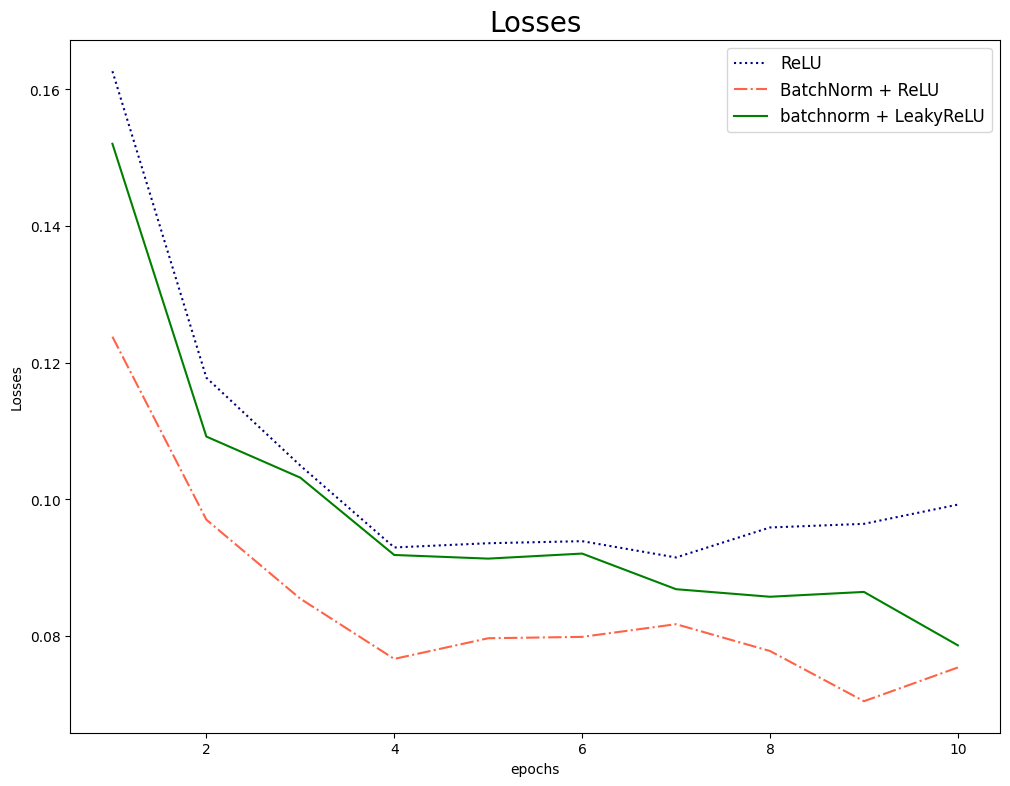

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,9))
plt.plot(np.arange(1, 11), history_a.history['val_loss'], color='navy', linestyle=':')
plt.plot(np.arange(1, 11), history_b.history['val_loss'], color='tomato', linestyle='-.')
plt.plot(np.arange(1, 11), history_c.history['val_loss'], color='green', linestyle='-')

plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['ReLU','BatchNorm + ReLU', 'batchnorm + LeakyReLU'], fontsize=12)
plt.show()

mnist 데이터셋은 모델별 차이가 크지 않다.

##**6. 모델 저장 및 불러오기**

###**6-1. 모델을 파일로 저장**

In [19]:
# 모델을 h5 포맷으로 저장: 대용량의 데이터를 저장하기 위한 파일 형식
model_c.save('h5-model.h5')

###**6-2. 저장된 모델 복원**

In [21]:
# 모델 복원
h5_model = tf.keras.models.load_model('h5-model.h5')
h5_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,036 (207.18 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

복원한 모델을 검증하여 복원이 잘 되었는지 확인한다.

In [22]:
# 모델 검증
loss, acc = h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5 model] loss: {loss:.5f}, acc: {acc:.5f}')

h5 model] loss: 0.07866, acc: 0.97700


.h5 확장자를 생략하면 SavedModel 포맷으로 저장되며, 이는 텐서플로2에서 기본으로 지원하는 파일 포맷이다.

In [24]:
# 모델을 SaveModel 포맷으로 저장
model_c.save('saved-model.keras')

In [26]:
# 모델 복원
saved_model = tf.keras.models.load_model('saved-model.keras')
saved_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,878 (413.59 KB)

 Trainable params: 52,842 (206.41 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 52,844 (206.43 KB)

In [27]:
# 모델 검증(HDF5 포맷)
loss, acc = h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5 model] loss: {loss:.5f}, acc: {acc:.5f}')

# 모델 검증(SavedModel 포맷)
loss, acc = saved_model.evaluate(x_test, y_test, verbose=0)
print(f'saved_model] loss: {loss:.5f}, acc:{acc:.5f}')

h5 model] loss: 0.07866, acc: 0.97700
saved_model] loss: 0.07866, acc:0.97700


##**7. 복잡한 모델 생성**

###**7-1. 함수형 API(Functional API)**

함수 형태로 딥러닝 모델을 정의하면 다양한 모델 구조를 구현할 수 있다. 여러 층을 시퀀스 형태로 연결하는 Sequential API와 다르게, Functional API는 복잡한 구조의 모델을 정의할 수 있다.  

함수의 입력 매개변수를 여러 개 갖는 다중 입력, 함수의 return 값을 여러 개 갖는 다중 출력, 같은 레벨에 여러 개의 층을 배치하여 입력과 출력을 공유하는 구조도 가능하다.  

Sequential API를 사용하는 경우 단방향의 Sequential 모델만 구현할 수 있다는 제약이 있다. 데이터 흐름이 특정 레이어를 건너뛰거나, 병합 및 분리하는 등의 구조의 모델을 구현할 수는 없다.

함수형 API를 사용하기 위해서는 먼저 Input 레이어를 정의한다.

In [28]:
# 모델의 레이어를 체인 구조로 연결 Input 레이어 정의
input_layer = tf.keras.Input(shape=(28,28), name='InputLayer')

# 모델의 레이어를 체인 구조로 연결
x1 = tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2 = tf.keras.layers.Dense(256, activation='relu', name='Dense1')(x1)
x3 = tf.keras.layers.Dense(64, activation='relu', name='Dense2')(x2)
x4 = tf.keras.layers.Dense(10, activation='softmax', name='OutputLayer')(x3)

레이어마다 name 매개변수로 이름을 부여할 수 있다.  

첫 Input 레이어로 시작하여 x4 변수는 마지막 출력층을 나타낸다.

In [29]:
# 모델 생성
func_model = tf.keras.Model(inputs=input_layer, outputs=x4, name='FunctionalModel')

# 모델 요약
func_model.summary()

Model: "FunctionalModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ InputLayer (InputLayer)              │ (None, 28, 28)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense1 (Dense)                       │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense2 (Dense)                       │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ OutputLayer (Dense)                  │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)

복잡한 구조를 갖는 모델을 생성할 때 summary()로는 모델의 구조도를 시각화하기 어렵다. 이때 plot_model 모듈을 활용하여 모델의 구조도를 시각화할 수 있다.

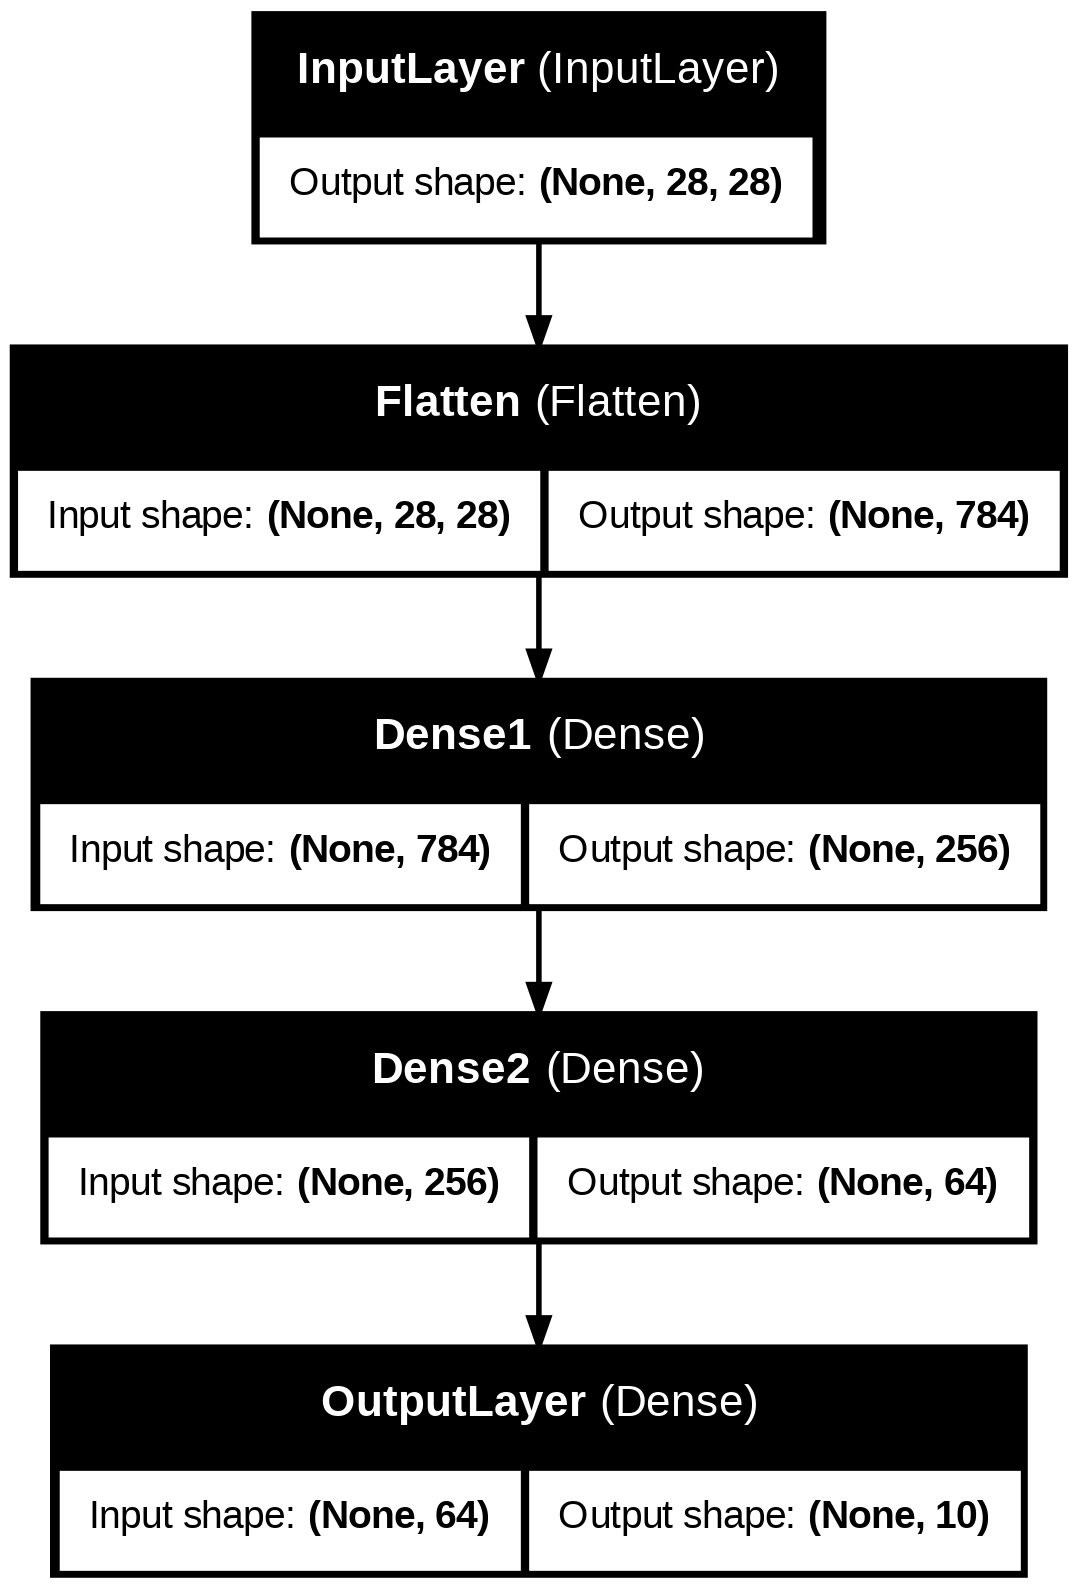

In [30]:
from tensorflow.keras.utils import plot_model

# 구조도 시각화
plot_model(func_model, show_shapes=True, show_layer_names=True, to_file='model.png')

함수형 API로 생성한 모델도 Sequential API로 생성한 모델과 동일한 방식으로 훈련할 수 있다. 생성된 모델 인스턴스에 compile() 메소드로 모델을 컴파일하고 fit() 메소드로 모델을 훈련한다. 훈련이 완료된 뒤 evaluate() 메소드로 검증한다.

In [31]:
# 컴파일
func_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
# 훈련
func_model.fit(x_train, y_train, epochs=3)
# 검증
loss, acc = func_model.evaluate(x_test, y_test, verbose=0)
print(f'Functional Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8929 - loss: 0.3721
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9718 - loss: 0.0926
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9816 - loss: 0.0579
Functional Model] loss: 0.08824, acc: 0.97180


###**7-2. 모델 서브클래싱(Model Subclassing)**

텐서플로 케라스는 Model 클래스를 제공하고, 이를 기반으로 딥러닝 모델을 구현하고 있는데, 이 클래스를 직접 상속받아 사용자가 직접 서브클래스로 딥러닝 모델을 만들 수도 있다.

In [49]:
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(64, activation='relu')
        self.dense3 = tf.keras.layers.Dense(10, activation='softmax')

    # method overiding
    # 훈련용 함수 정의
    # x는 input
    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

In [50]:
# 모델 생성
mymodel=MyModel()

# 모델의 이름 설정
mymodel._name='subclass_model'

# 모델의 input 정의
mymodel(tf.keras.layers.Input(shape=(28,28)))

# 모델 요약
mymodel.summary()

Model: "my_model_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)                 │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 256)                 │         200,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 218,058 (851.79 KB)

 Trainable params: 218,058 (851.79 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# 컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 훈련
mymodel.fit(x_train, y_train, epochs=3)

# 검증
loss, acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model]loss:{loss:.5f}, acc:{acc:.5f}')

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8925 - loss: 0.3653
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9734 - loss: 0.0881
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9827 - loss: 0.0547
Subclassing Model]loss:0.07118, acc:0.97730


###**7-3. 서브클래싱 모델 파라미터를 활용한 생성**

Model Subclassing으로 생성하는 장점은 생성자 파라미터로 모델 내부 레이어의 하이퍼파라미터를 지정할 수 있다는 점이다. 다음은 모델의 생성자 파라미터를 추가하여 동적으로 레이어의 유닛 개수를 초기화하는 예제이다.

In [57]:
class MyModel(tf.keras.Model):

    # 생성자 파라미터 추가
    def __init__(self, units, num_classes):
        super(MyModel,self).__init__()
        #초기값 설정
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(units, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units/4, activation='relu')
        self.dense3 = tf.keras.layers.Dense(num_classes, activation='softmax')

    # class overiding
    # 훈련용 함수 정의
    # x는 input
    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

모델의 생성자 파라미터로 기준이 되는 unit의 개수를 입력받아 Dense 레이어의 유닛 개수를 계산하여 설정한다.

In [ ]:
### 아래 두 셀에서 오류 발생. 오타 없음 확인.

In [ ]:
# 모델 생성
mymodel = MyModel(256,10)

# 모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28,28)))

# 모델 요약
mymodel.summary()

In [ ]:
mymodel.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

mymodel.fit(x_train, y_train, epochs=3)

loss,  acc = mymodel.evaluate(x_test, y_test, verbose=0)
print(f"Subclassing Model w.parameters] loss : {loss:.5f}.acc : {acc:.5f}")